In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn import metrics
from scipy.spatial.distance import cdist
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold

def get_time_as_float(dt):
    ls = re.findall(r'[0-9]+', dt)
    ret = datetime(*[int(i) for i in ls]).timestamp()
    return ret

def transform_data(ls):
    ret = []
    for i in range(len(ls)):
        ret.append(get_time_as_float(ls[i]) if i == 0 else float(ls[i]))
    
    return ret

# Load Digit Data
data, target = load_digits(return_X_y = True)

# Load Occupancy Data
f = open('datatraining.txt', 'r')
lines = [line.strip().split(',')[1:] for line in f.readlines()[1:]]
occData, occTarget = [line[:-1] for line in lines], [line[-1] for line in lines]
f.close()

occData = np.array([transform_data(ls) for ls in occData])



/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


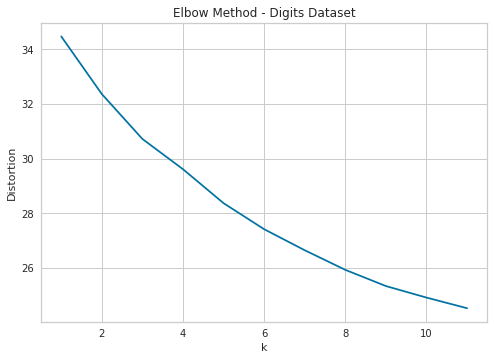

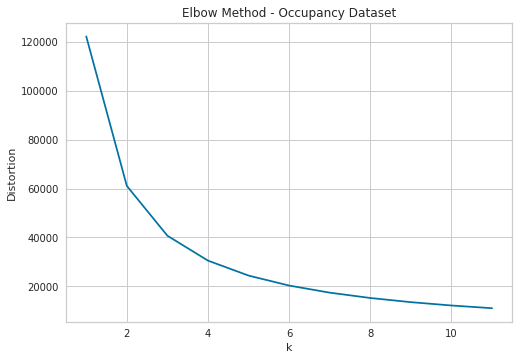

In [18]:
# Determine Best K for each Dataset using Elbow Method

# Digits Dataset
distortions = []
K = range(1,12)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=5).fit(data)
    kmeanModel.fit(data)
    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    
plt.plot([k for k in K], distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("Elbow Method - Digits Dataset")
plt.show()

# Occupancy Dataset
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(occData)
    kmeanModel.fit(occData)
    distortions.append(sum(np.min(cdist(occData, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / occData.shape[0])
    
plt.plot([k for k in K], distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("Elbow Method - Occupancy Dataset")
plt.show()

In [120]:
# # Determine Best K - Silhouette Method
# ss = metrics.silhouette_score

# # Digits Dataset
# K = range(2, 20) # Silhouette requires at least 2 labels, so one cannot be used

# best_k = 0
# best_silScore = -np.inf
# best_estimator = None
# for k in K:
#     km = KMeans(n_clusters=k, random_state=2738283).fit(data)
#     km.fit(data)
#     score = ss(data, km.labels_)
#     if score > best_silScore:
#         best_silScore = score
#         best_k = k
#         best_estimator = km
    
# print(best_k)
# print(best_estimator.labels_)

# # Occupancy Dataset
# best_k = 0
# best_silScore = -np.inf
# best_estimator = None
# for k in K:
#     km = KMeans(n_clusters=k).fit(occData)
#     km.fit(occData)
#     score = ss(occData, km.labels_)
#     if score > best_silScore:
#         best_silScore = score
#         best_k = k
#         best_estimator = km
# print(best_k)
# print(len(best_estimator.labels_))



10
[6 6 6 ... 3 3 3]
2
8143


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [22]:
def show_silhouette(range_n_clusters, data):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.11832841100655983


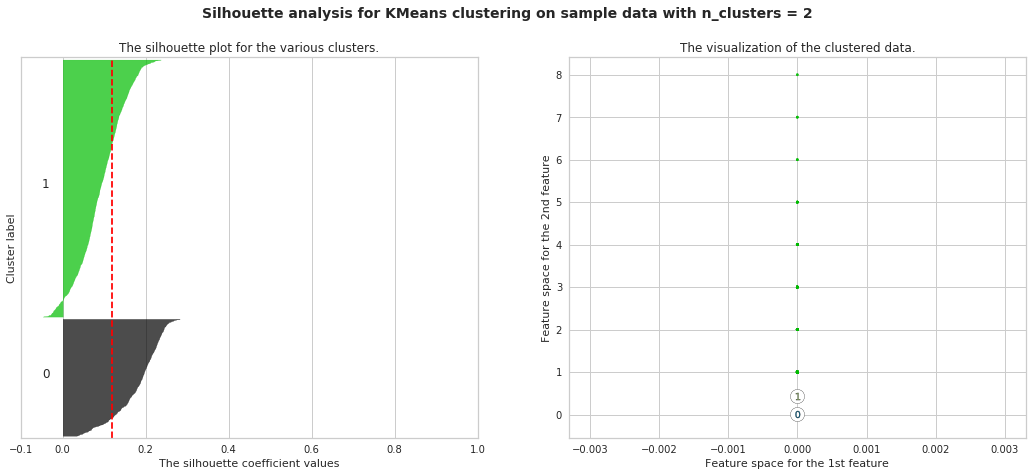

For n_clusters = 3 The average silhouette_score is : 0.1265024495405014


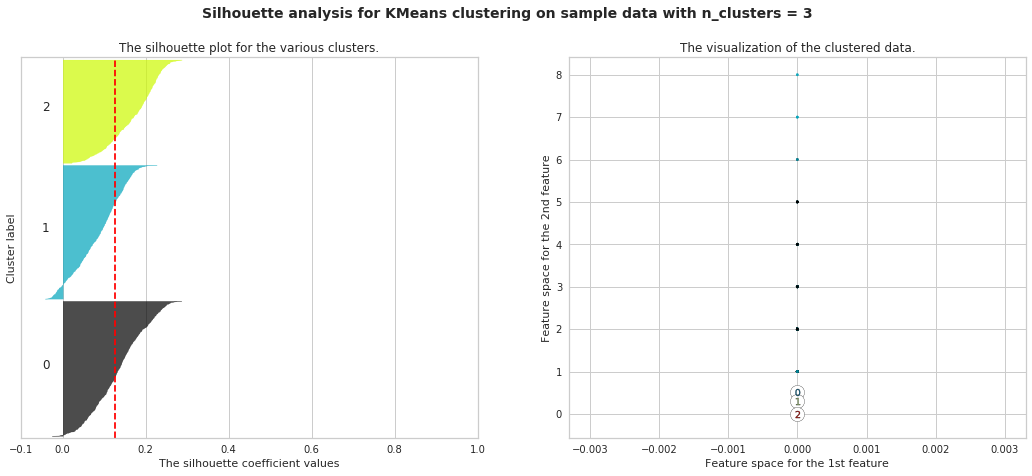

For n_clusters = 4 The average silhouette_score is : 0.12801530390921514


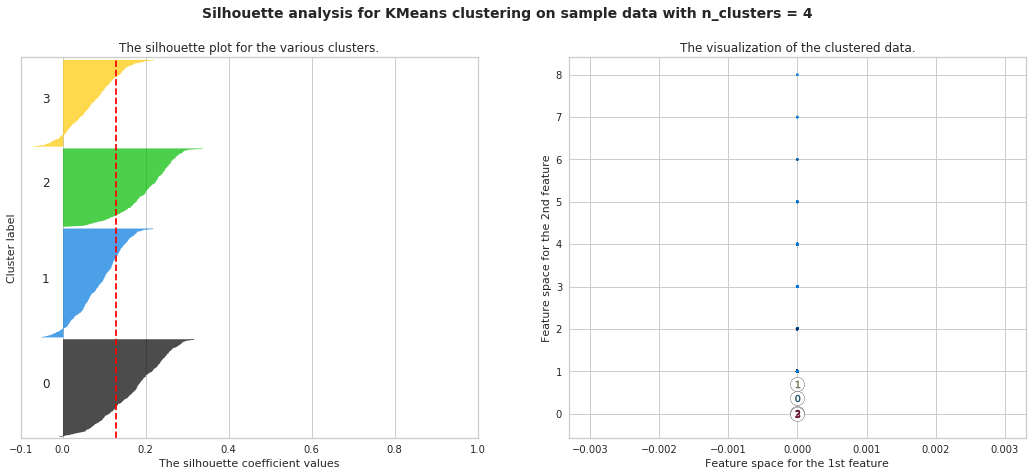

For n_clusters = 5 The average silhouette_score is : 0.1378892361397985


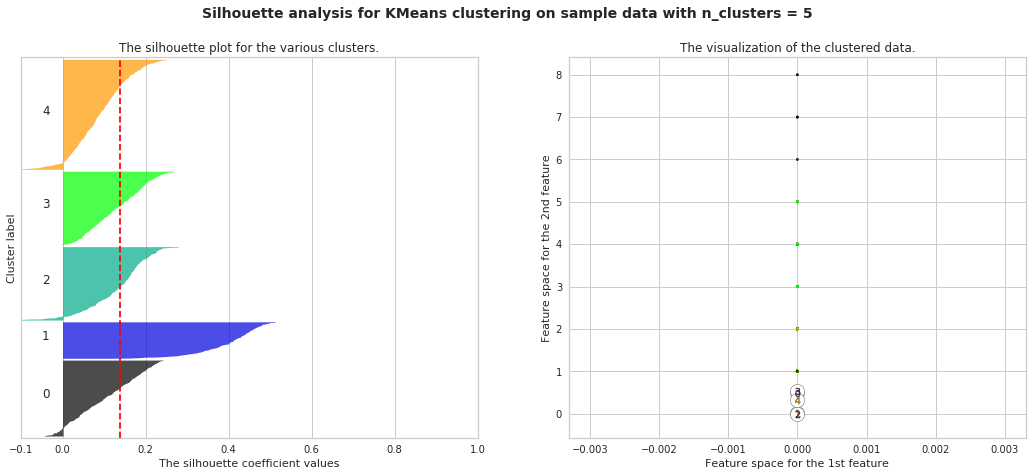

For n_clusters = 6 The average silhouette_score is : 0.15057983781949263


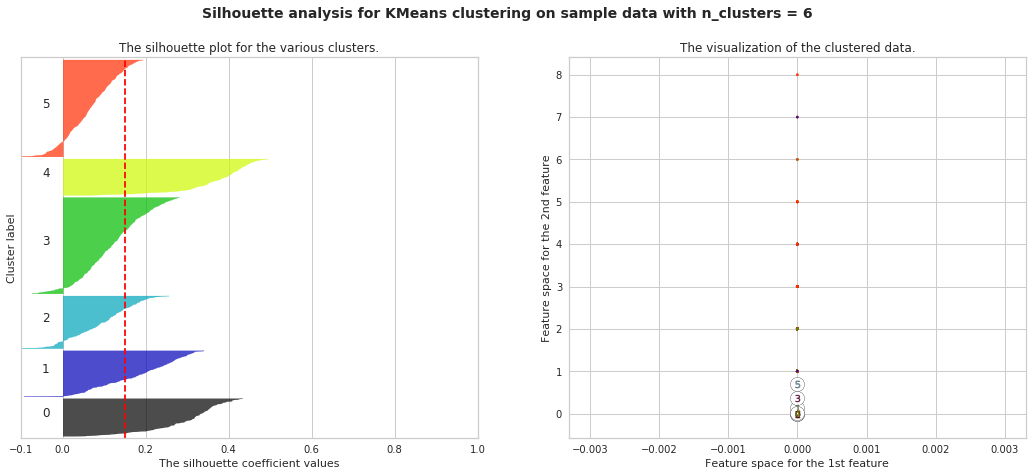

For n_clusters = 7 The average silhouette_score is : 0.16178742295975607


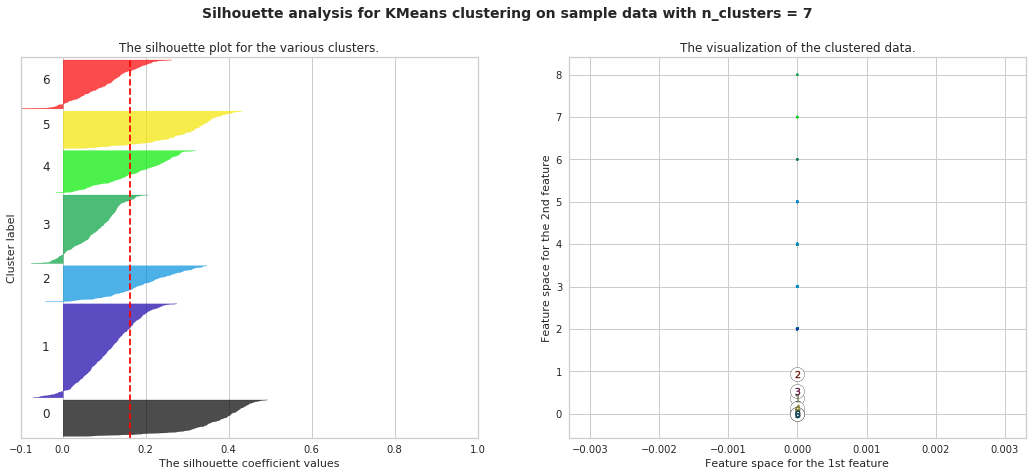

For n_clusters = 8 The average silhouette_score is : 0.17872647072546718


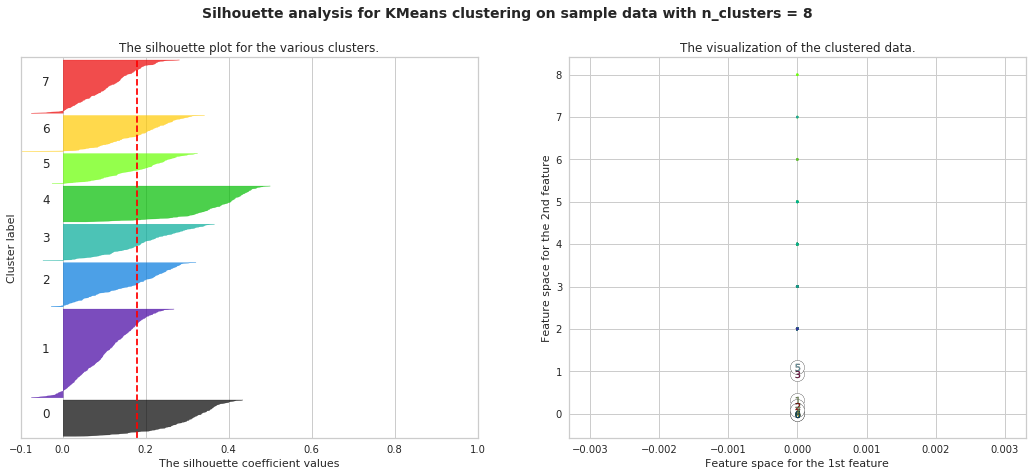

For n_clusters = 9 The average silhouette_score is : 0.18905653592938348


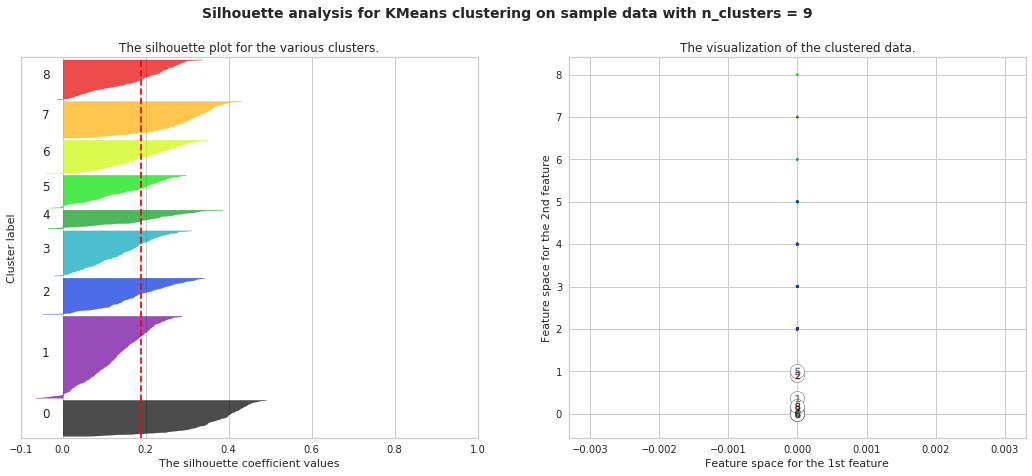

For n_clusters = 10 The average silhouette_score is : 0.182553978676142


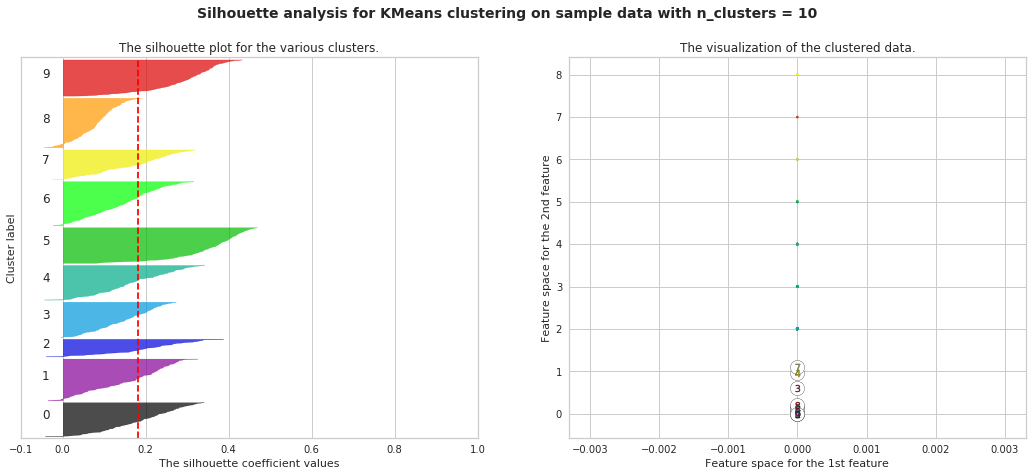

For n_clusters = 11 The average silhouette_score is : 0.18067678626453276


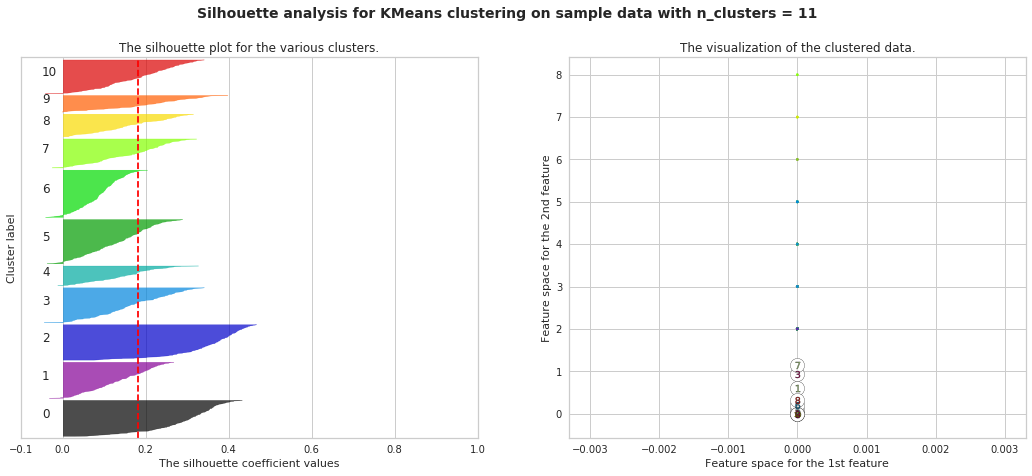

For n_clusters = 12 The average silhouette_score is : 0.1831071215545391


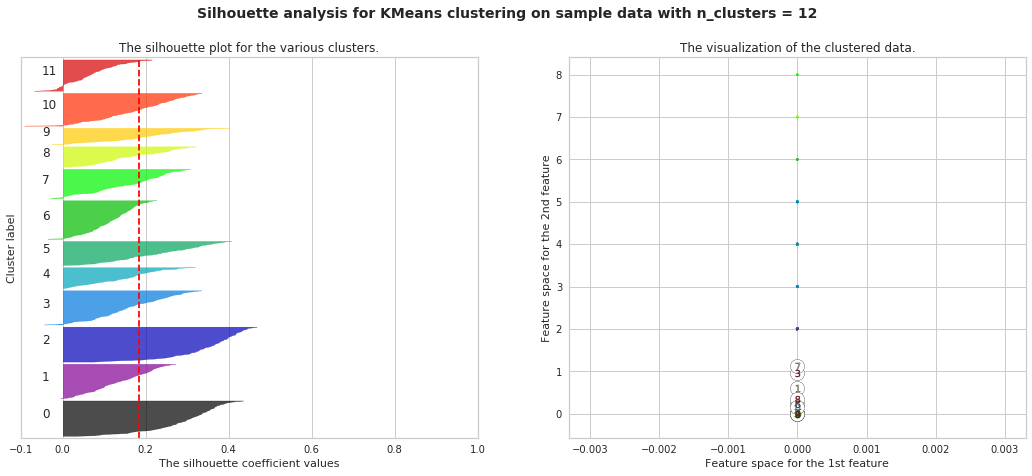

For n_clusters = 13 The average silhouette_score is : 0.18503695117034843


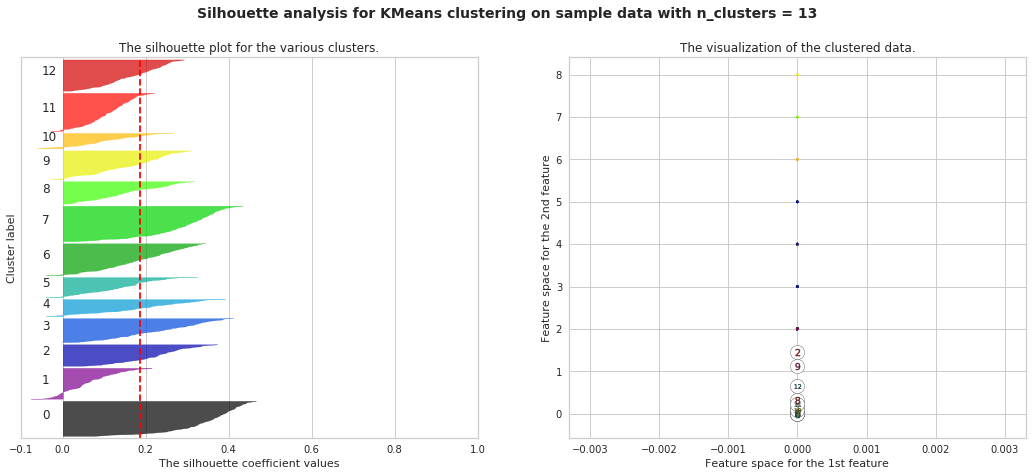

For n_clusters = 14 The average silhouette_score is : 0.18788950828616338


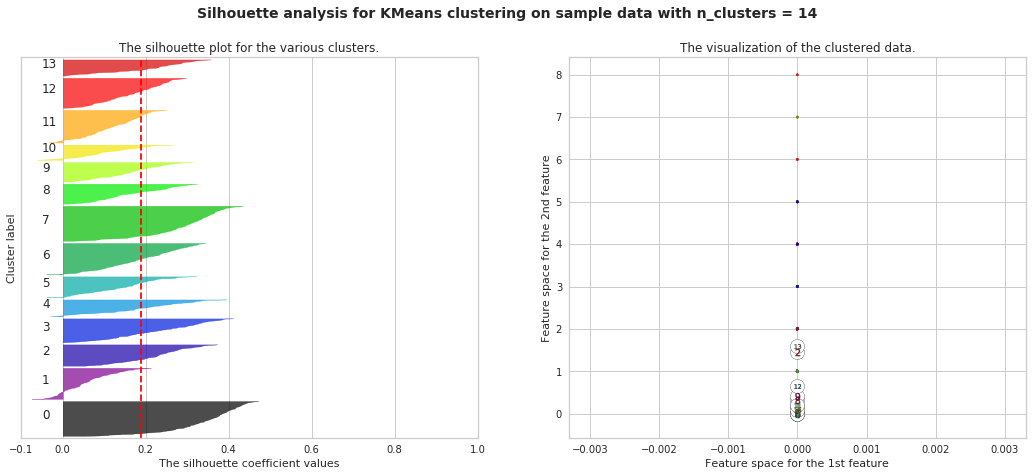

For n_clusters = 2 The average silhouette_score is : 0.6266330520534437


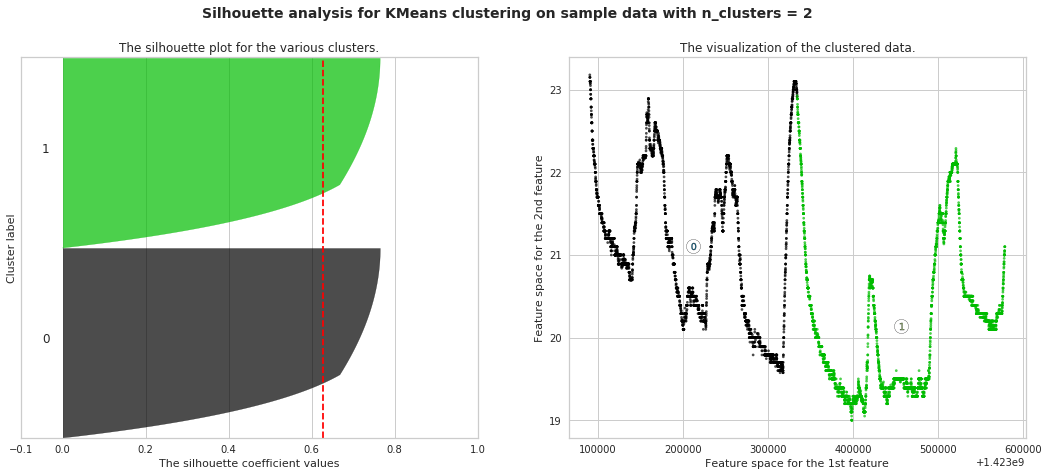

For n_clusters = 3 The average silhouette_score is : 0.5900240806080063


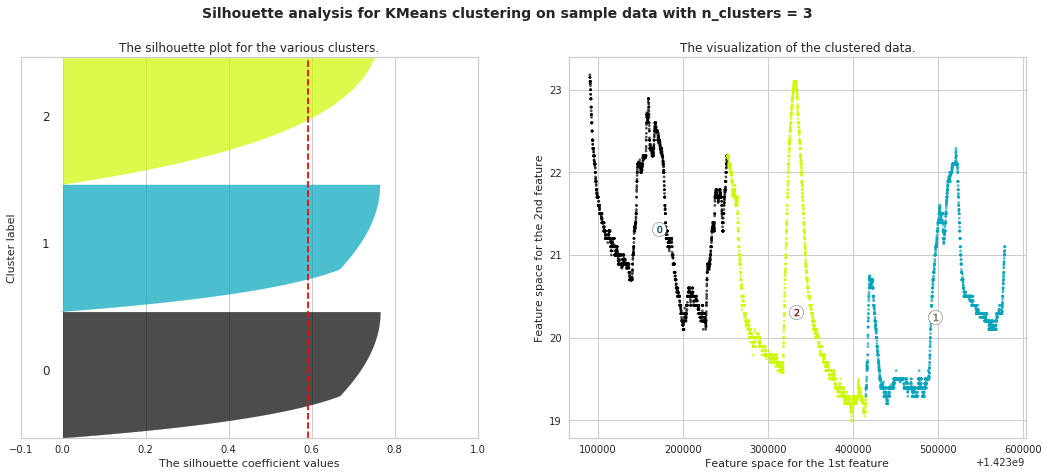

For n_clusters = 4 The average silhouette_score is : 0.5716795086839481


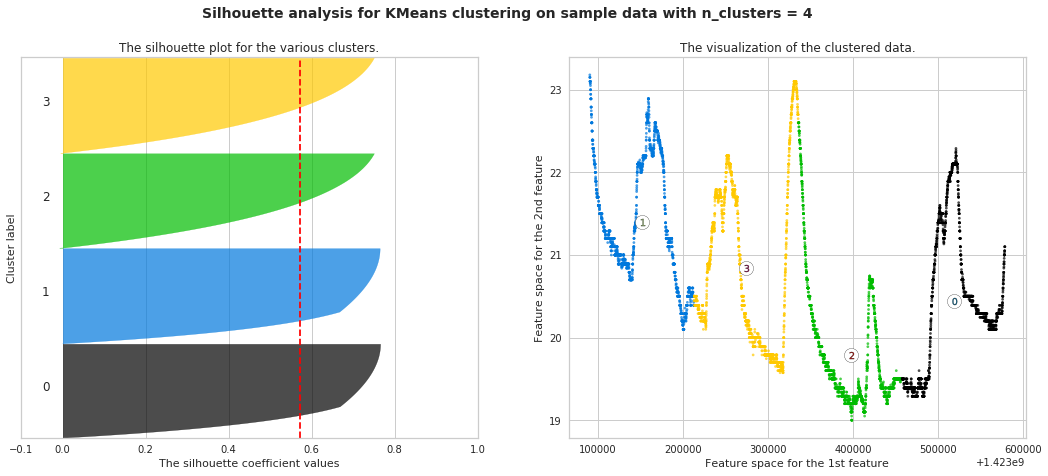

For n_clusters = 5 The average silhouette_score is : 0.5606454799232427


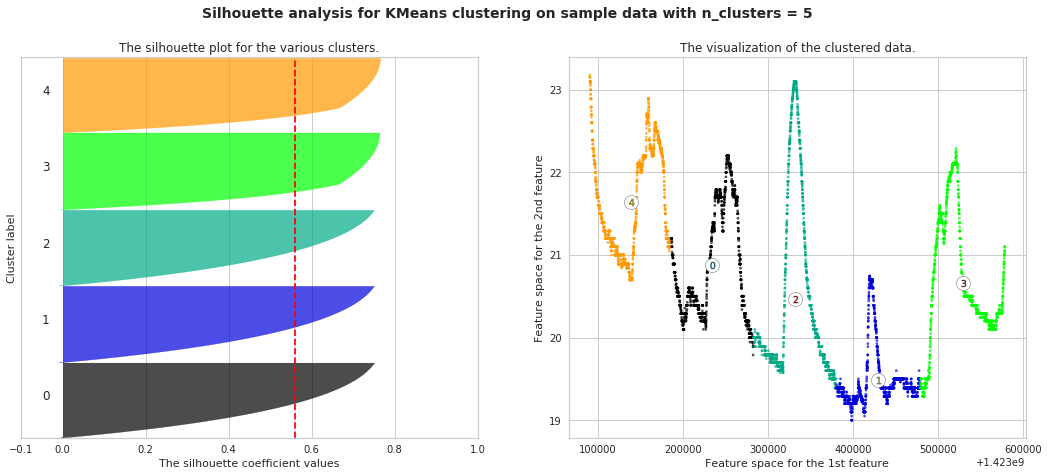

For n_clusters = 6 The average silhouette_score is : 0.5531584086638885


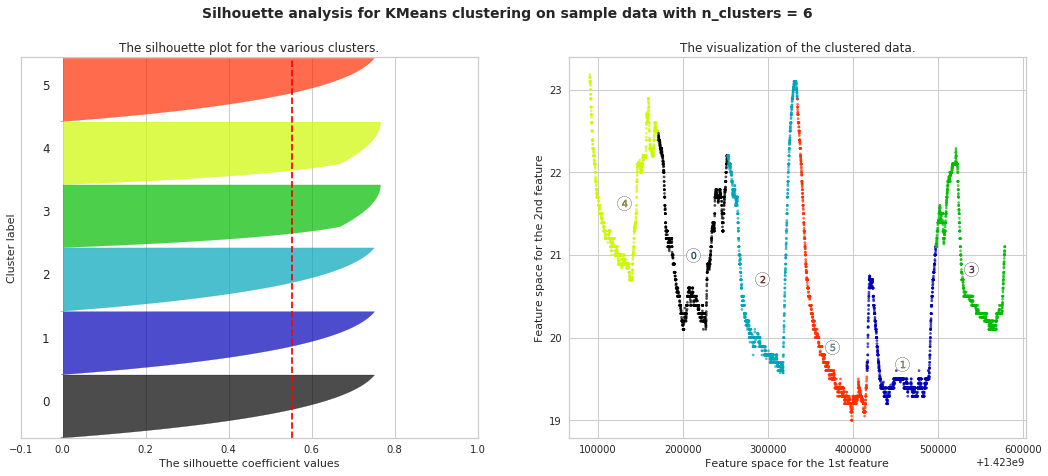

For n_clusters = 7 The average silhouette_score is : 0.548006498295263


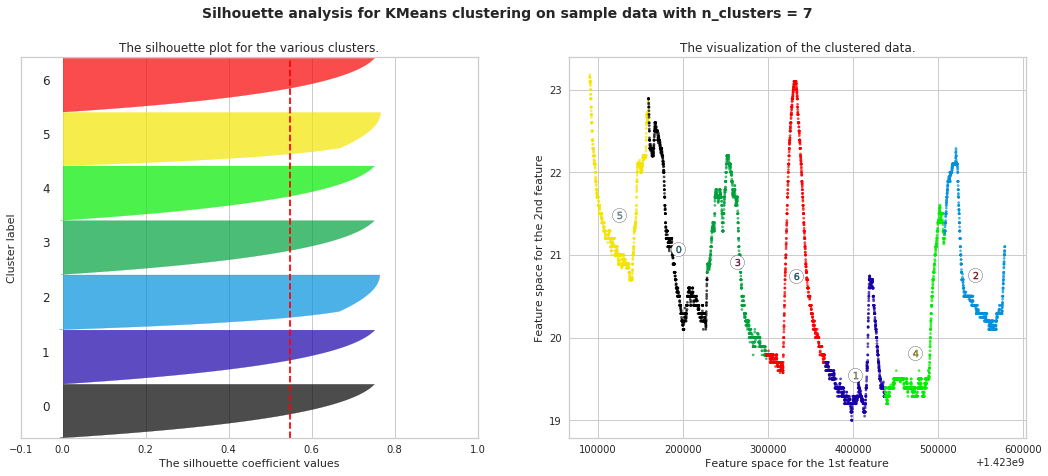

For n_clusters = 8 The average silhouette_score is : 0.5442000882550252


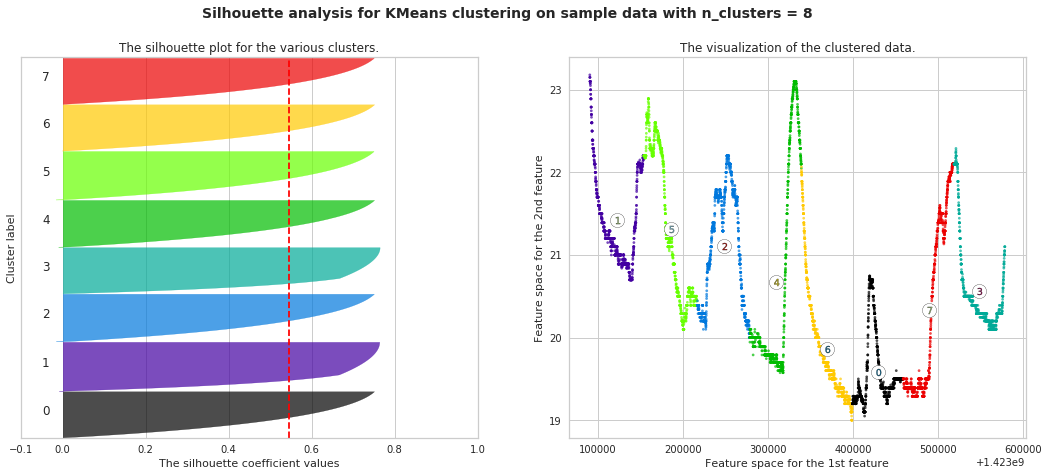

For n_clusters = 9 The average silhouette_score is : 0.5411930105418541


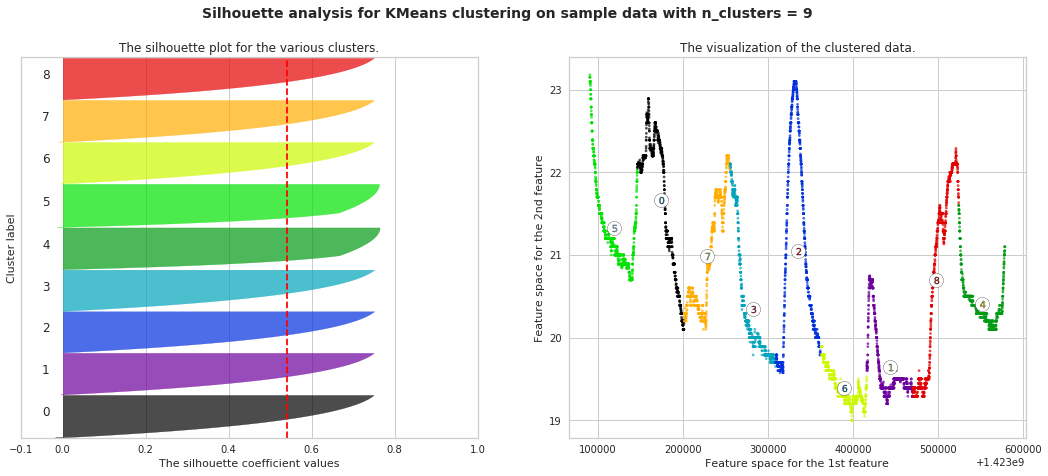

For n_clusters = 10 The average silhouette_score is : 0.5387509578720459


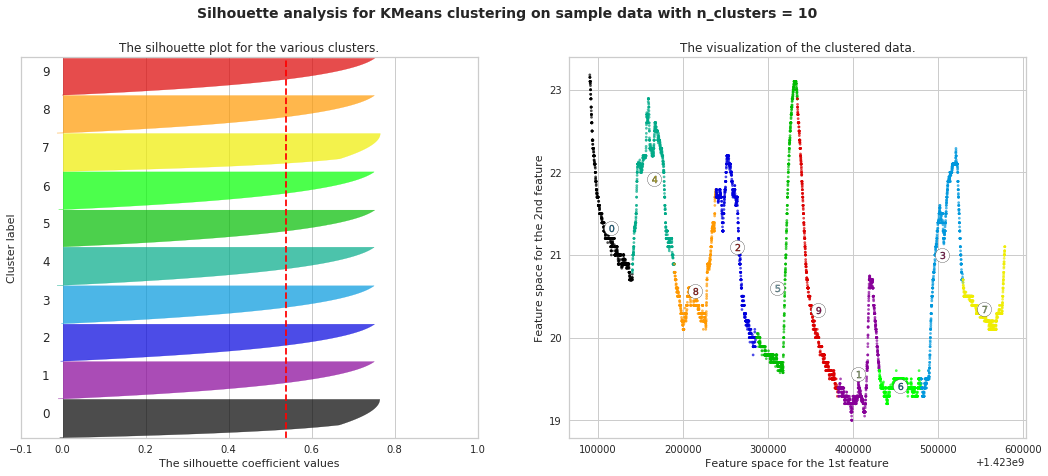

For n_clusters = 11 The average silhouette_score is : 0.5362000538930083


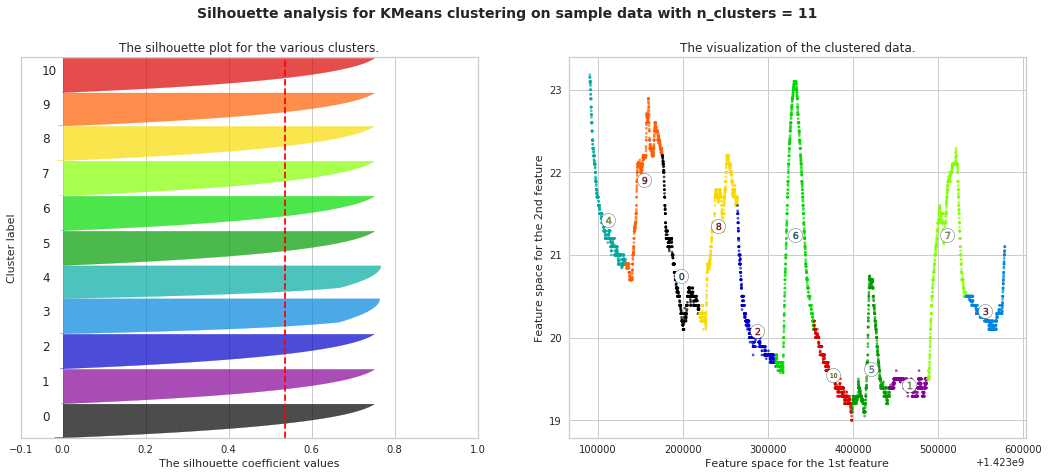

For n_clusters = 12 The average silhouette_score is : 0.5339916092815221


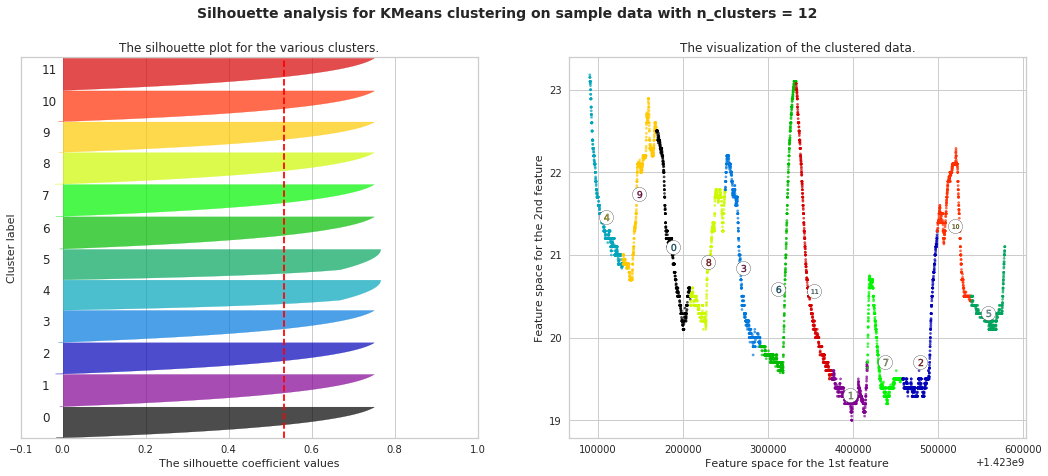

For n_clusters = 13 The average silhouette_score is : 0.5337581470789241


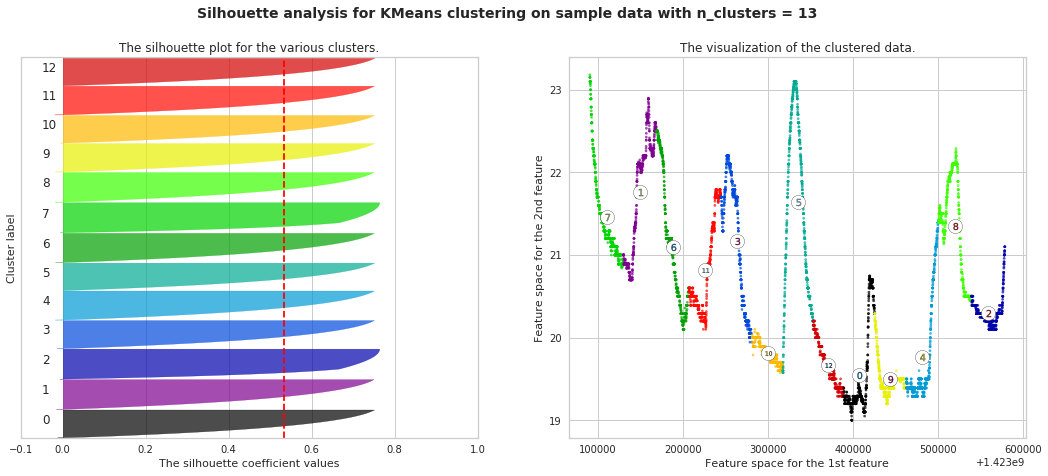

For n_clusters = 14 The average silhouette_score is : 0.5319247620713455


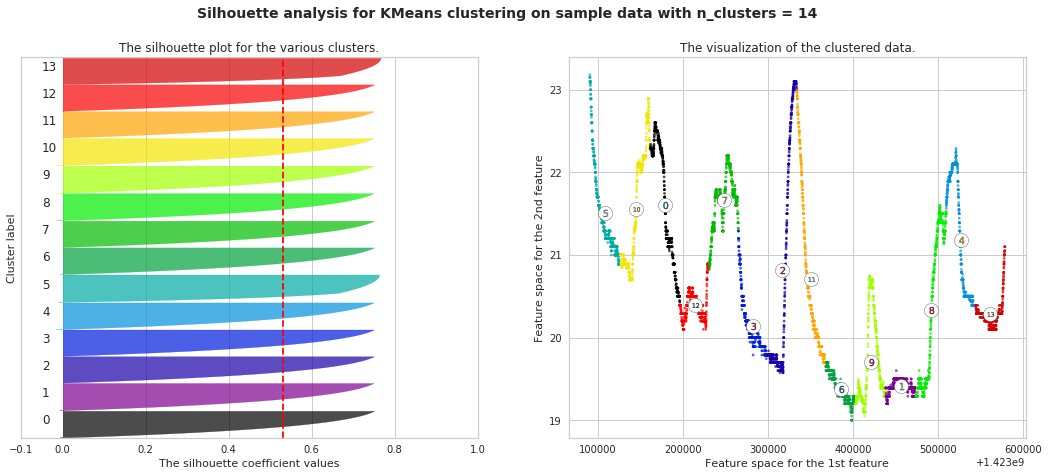

In [25]:
# Record Silhouette Scores and Print Graphs for Digit Data
show_silhouette(range(2, 15), data)

# Record Silhouette Scores and Print Graphs for Occupancy Data
show_silhouette(range(2, 15), occData)

In [27]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()


NameError: name 'iris' is not defined

[[ 5. 13.]
 [ 0. 12.]
 [ 0.  4.]
 ...
 [ 1. 11.]
 [ 2. 10.]
 [10. 14.]]


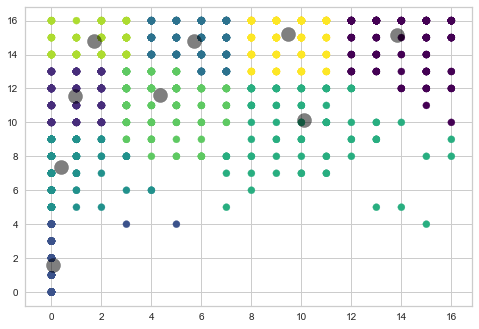

In [22]:
kmeans = KMeans(n_clusters=9)
d = np.array([[x[2],x[3]] for x in data])
scale(d)
print(d)
kmeans.fit(d)
y_means = kmeans.predict(d)
# print(y_means)
plt.scatter(d[:, 0], d[:, 1], c=y_means, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[[ 8.36856841e-01  2.13635938e+00]
 [-1.41365810e+00  7.40962324e+00]
 [ 1.15521298e+00  5.09961887e+00]
 [-1.01861632e+00  7.81491465e+00]
 [ 1.27135141e+00  1.89254207e+00]
 [ 3.43761754e+00  2.61654166e-01]
 [-1.80822253e+00  1.59701749e+00]
 [ 1.41372442e+00  4.38117707e+00]
 [-2.04932168e-01  8.43209665e+00]
 [-7.11099611e-01  8.66043846e+00]
 [-1.71237268e+00  2.77780226e+00]
 [-2.67000792e+00  8.35389140e+00]
 [ 1.24258802e+00  4.50399192e+00]
 [-2.22783649e+00  6.89479938e+00]
 [ 1.45513831e+00 -2.91989981e-02]
 [ 4.53791789e-01  3.95647753e+00]
 [ 1.06923853e+00  4.53068484e+00]
 [ 2.56936589e+00  5.07048304e-01]
 [-1.06690610e+00  3.13165795e+00]
 [-1.07859101e+00  2.20451529e+00]
 [ 2.71506328e+00  1.29082190e+00]
 [ 1

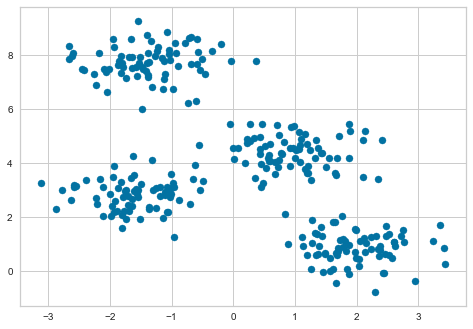

In [15]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
print(data[0])
print(X)
plt.scatter(X[:, 0], X[:, 1], s=50);